# DL Model: Time Series Forecasting with Stock Data Only

Modified from the TensorFlow tutorial on time series forecasting, including code and text with variable names and vocabulary adjusted to fit the stock data problem: https://www.tensorflow.org/tutorials/structured_data/time_series

## Setup

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random
import re
import os

from collections import Counter
from nltk.corpus import stopwords

import seaborn as sns
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, RNN, Bidirectional, Dense, Embedding, TextVectorization, Flatten, Input, Dropout

import warnings
warnings.filterwarnings('ignore')


2022-12-19 14:46:11.958415: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
date_today = datetime.now().date()
print(f'Last updated {date_today}')


Last updated 2022-12-19


## Load the news data to determine which stocks to consider


In [3]:
verbose = 0
news_dir = '../data'
news_folders = ['scraped_news_from_api', 'scraped_news_from_html']
date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date()
news_df = pd.DataFrame()
for folder in news_folders:
    for news_file in os.listdir(os.path.join(news_dir, folder)):
        if not news_file.endswith('.csv'):
            continue
        tmp_df = pd.read_csv(os.path.join(news_dir, folder, news_file), parse_dates=['publish_date'], date_parser=date_parser)
        if verbose > 0:
            print(f'{news_file}\t({tmp_df.shape[0]})')
        news_df = pd.concat([news_df, tmp_df])
    
news_df = news_df.drop(columns=['scrape_date', 'related_tickers']).sort_values('publish_date').rename(columns={'index': 'stock'})
news_df = news_df.drop_duplicates(subset=['stock', 'url'], keep='last').reset_index(drop=True)

print(f'Number of articles: {news_df.shape[0]}')
print(f'Number of stocks: {len(np.unique(news_df["stock"]))}')
print(f'Date range: {min(news_df["publish_date"]).date()} to {max(news_df["publish_date"]).date()}')

news_df


Number of articles: 6730
Number of stocks: 161
Date range: 2022-09-02 to 2022-12-19


,stock,url,news,headlines,raw_publish_date,publish_date
0,SPOT,http://www.finance.yahoo.com/news/legendary-mu...,"Mega-hit song ""Gangnam Style"" by K-pop singer ...","['Yahoo Finance', 'Legendary music producer: ‘...","September 2, 2022, 10:32 AM",2022-09-02
1,HMC,http://www.finance.yahoo.com/news/supply-chain...,Supply chain issues have hampered the auto ind...,"['Yahoo Finance', 'Supply chains still hamperi...","October 6, 2022, 2:46 AM",2022-10-06
2,JBLU,http://www.finance.yahoo.com/news/airline-stoc...,Airline stocks are so cheap from a valuation p...,"['Yahoo Finance', 'Airline stocks just need a ...","October 12, 2022, 2:11 PM",2022-10-12
3,AAL,http://www.finance.yahoo.com/news/airline-stoc...,Airline stocks are so cheap from a valuation p...,"['Yahoo Finance', 'Airline stocks just need a ...","October 12, 2022, 2:11 PM",2022-10-12
4,SAVE,http://www.finance.yahoo.com/news/airline-stoc...,Airline stocks are so cheap from a valuation p...,"['Yahoo Finance', 'Airline stocks just need a ...","October 12, 2022, 2:11 PM",2022-10-12
...,...,...,...,...,...,...
6725,ADBE,https://finance.yahoo.com/news/company-news-de...,Shares of Adobe Inc. ADBE surged 3% after the ...,"['Yahoo Finance', 'Company News for Dec 19, 20...","December 19, 2022, 6:24 AM",2022-12-19
6726,BYDDY,https://finance.yahoo.com/news/most-dramatic-s...,(Bloomberg) -- From a little-known manufacturi...,"['Yahoo Finance', 'Most Dramatic Stock Moves o...","December 19, 2022, 7:23 AM",2022-12-19
6727,INTC,https://finance.yahoo.com/news/intels-german-a...,Intel Corp (NASDAQ: INTC) retreated from its i...,"['Yahoo Finance', ""Intel's German Ambitions Hi...","December 19, 2022, 5:03 AM",2022-12-19
6728,AZN,https://finance.yahoo.com/news/astrazeneca-dru...,AstraZeneca Plc (NASDAQ: AZN) announced toplin...,"['Yahoo Finance', 'AstraZeneca Drug Imfinzi Fa...","December 19, 2022, 2:48 AM",2022-12-19


## Download the stock data

In [4]:
N_STOCK_UNITS = 2
STOCK_UNIT = 'y'     # years = 'y', months = 'mo'
indices = list(np.unique(news_df['stock']))
history_df = yf.download(indices, period=f'{N_STOCK_UNITS}{STOCK_UNIT}')
close_df = history_df['Close']

for c in close_df.columns:
    if close_df.isna().sum()[c] > 0:
        c_mean = np.mean(close_df[c])
        close_df[c] = close_df[c].fillna(c_mean)
        
print(f'Shape: {close_df.shape}')
close_df.head()


[*********************100%***********************]  161 of 161 completed
Shape: (503, 161)


,AAL,AAPL,ACI,ADBE,ADDYY,AGCO,AJRD,ALK,AMD,AMZN,...,WMG,WMT,WRBY,X,XOM,XPEV,ZEUS,ZM,^GSPC,^IXIC
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-21,16.100000,128.229996,15.35,498.390015,177.610001,103.269997,52.770000,50.220001,93.230003,160.309006,...,37.520000,145.970001,27.171473,17.379999,41.950001,46.970001,13.47,408.970001,3694.919922,12742.519531
2020-12-22,15.480000,131.880005,15.81,504.170013,178.630005,103.099998,52.799999,50.349998,93.160004,160.326004,...,37.599998,144.199997,27.171473,16.879999,41.240002,45.049999,13.15,409.000000,3687.260010,12807.919922
2020-12-23,15.890000,130.960007,15.55,496.910004,179.279999,103.650002,52.799999,51.840000,91.550003,159.263504,...,38.020000,143.220001,27.171473,16.870001,41.770000,43.799999,13.62,383.880005,3690.010010,12771.110352
2020-12-24,15.660000,131.970001,15.75,499.859985,180.419998,103.209999,52.849998,52.250000,91.809998,158.634506,...,37.450001,143.500000,27.171473,16.790001,41.599998,41.869999,13.75,375.170013,3703.060059,12804.730469
2020-12-28,16.059999,136.690002,15.98,498.950012,182.570007,102.180000,52.740002,52.580002,91.599998,164.197998,...,37.330002,145.220001,27.171473,16.309999,41.740002,38.009998,13.24,351.390015,3735.360107,12899.419922


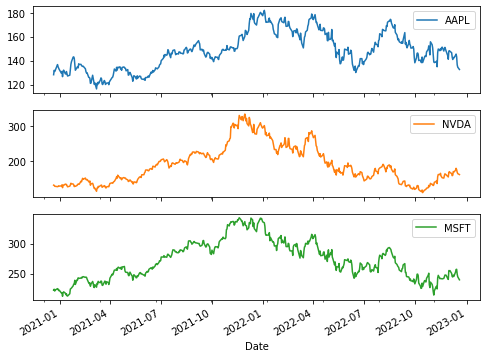

In [5]:
# display the close values for a few stocks over the past N_MONTHS
plot_cols = ['AAPL', 'NVDA', 'MSFT']
plot_features = close_df[plot_cols]
plot_features.index = close_df.index
_ = plot_features.plot(subplots=True)



### Inspect and cleanup

In [6]:
close_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AAL,503.0,17.863161,3.329741,11.860000,14.755000,17.840000,20.445001,25.820000
AAPL,503.0,147.925865,15.474661,116.360001,135.379997,147.059998,159.260002,182.009995
ACI,503.0,25.694968,5.825696,15.350000,20.020000,27.100000,30.049999,36.810001
ADBE,503.0,481.127426,108.001219,275.200012,403.179993,473.440002,569.324982,688.369995
ADDYY,503.0,132.088509,43.990999,45.500000,89.785000,144.110001,173.010002,198.679993
...,...,...,...,...,...,...,...,...
XPEV,503.0,32.027445,12.273956,6.410000,24.179999,34.110001,41.580000,56.389999
ZEUS,503.0,27.256461,5.782963,13.150000,24.030000,27.209999,30.730000,42.459999
ZM,503.0,215.399744,117.782913,69.411102,105.564999,185.250000,331.404999,444.510010
^GSPC,503.0,4184.234974,304.854629,3577.030029,3918.714966,4181.169922,4436.635010,4796.560059


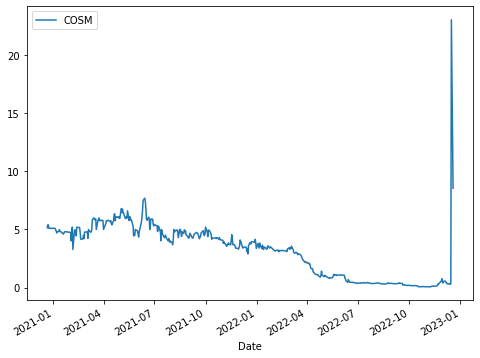

In [7]:
# notice that the last two values for the 'COSM' stock is unusually large
plot_cols = ['COSM']
plot_features = close_df[plot_cols]
plot_features.index = close_df.index
_ = plot_features.plot(subplots=True)


In [8]:
# we do not adjust this value, as checking Yahoo Finance reveals this to be the true value for this stock


### Split the data

In [9]:
# use a 70-20-10 train-val-test split
# do not shuffle before splitting to ensure that windows contain values that are consecutive in time,
# and to condition on the past (train) for future predictions (test)
column_indices = {name: i for i, name in enumerate(close_df.columns)}

n = len(close_df)
train_df = close_df[0:int(n*0.7)]
val_df = close_df[int(n*0.7):int(n*0.9)]
test_df = close_df[int(n*0.9):]

n_stocks = close_df.shape[1]

### Normalize the data


In [10]:
# apply a standard scaler to the stock values grouped by stock or index
ss = StandardScaler()
train_df[train_df.columns] = ss.fit_transform(train_df[train_df.columns])
val_df[val_df.columns] = ss.transform(val_df[val_df.columns])
test_df[test_df.columns] = ss.transform(test_df[test_df.columns])


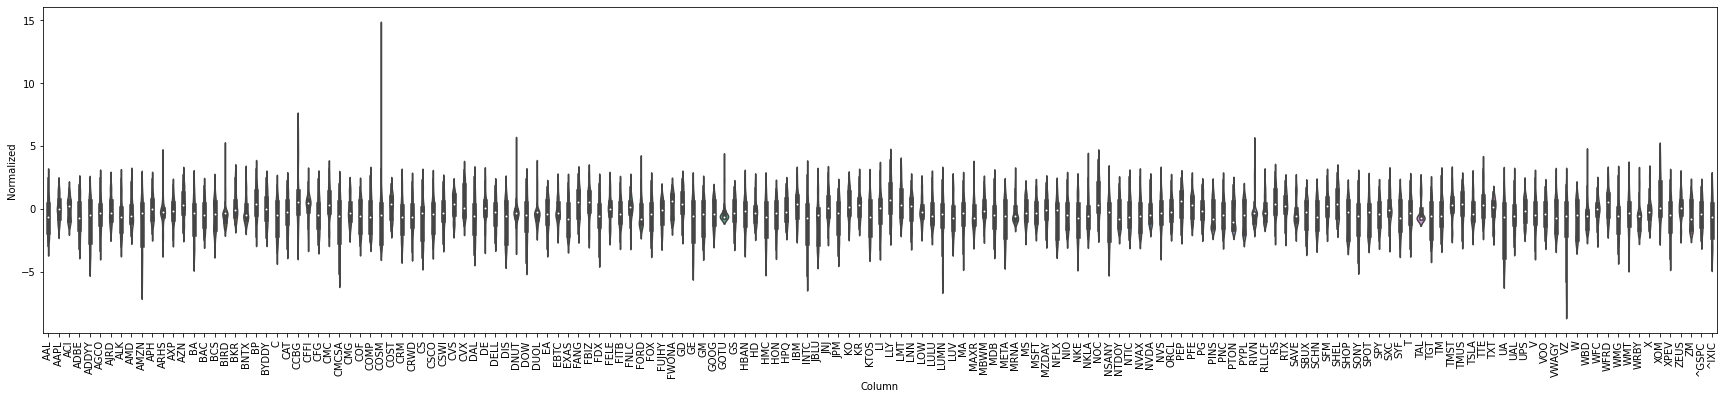

In [11]:
# check the distribution of the stocks
df_std = (close_df - train_df.mean()) / train_df.std()
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(30, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(close_df.keys(), rotation=90)

## Data windowing

The models in this notebook will make a set of predictions based on a window of consecutive samples from the data. 

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both. 

We will build a variety of models (including Linear, DNN, CNN and RNN models), and use them for *single-output*, *single-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [12]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [13]:
# generate windows that use 6 days of data to predict the next day 
w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['AAPL'])
w1


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['AAPL']

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.


In [14]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 161)
Inputs shape: (3, 6, 161)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 161 features at each time step. It splits them into a batch of 6-time step 161-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['AAPL']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [16]:
w1.example = example_inputs, example_labels

In [17]:
def plot(self, model=None, plot_col='AAPL', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot


This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

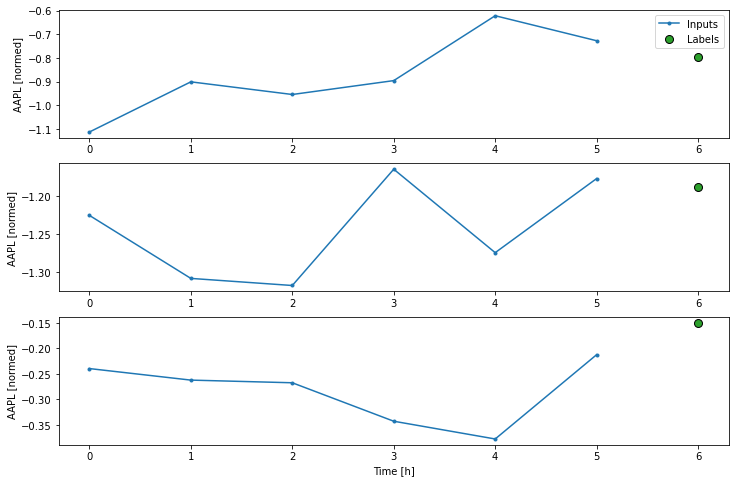

In [18]:
w1.plot()

You can plot the other columns, but the example window `w1` configuration only has labels for the `AAPL` column.

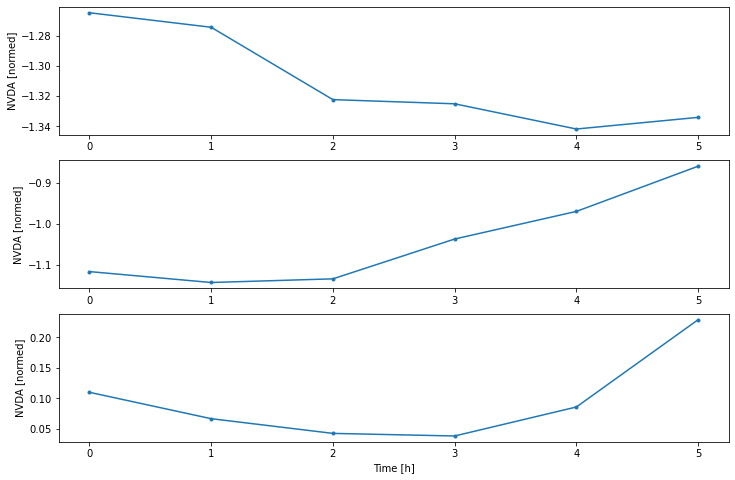

In [19]:
w1.plot(plot_col='NVDA')

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [20]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [21]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [22]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 6, 161), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [23]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 161)
Labels shape (batch, time, features): (32, 1, 1)


## Single step models

The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step (one day) into the future based only on the current conditions.

So, start by building models to predict the `AAPL` value one day into the future.

Configure a `WindowGenerator` object to produce these single-step `(input, label)` pairs:

In [24]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['AAPL'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['AAPL']

The `window` object creates `tf.data.Dataset`s from the training, validation, and test sets, allowing you to easily iterate over batches of data.


In [25]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 161)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict `AAPL` one day into the future, given the current value of all features. The current values include the current stock value. 

So, start with a model that just returns the current close value as the prediction, predicting "No change". This is a reasonable baseline since close value changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.


In [26]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]
    

Instantiate and evaluate this model:

In [27]:
baseline = Baseline(label_index=column_indices['AAPL'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

4/4 [==============================] - 0s 1ms/step - loss: 0.0348 - mean_absolute_error: 0.1464


That printed some performance metrics, but those don't give you a feeling for how well the model is doing.

The `WindowGenerator` has a plot method, but the plots won't be very interesting with only a single sample.

So, create a wider `WindowGenerator` that generates windows consecutive inputs and labels at a time. The new `wide_window` variable doesn't change the way the model operates. The model still makes predictions one day into the future based on a single input time step. Here, the `time` axis acts like the `batch` axis: each prediction is made independently with no interaction between time steps:

In [28]:
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1,     # 2 weeks
    label_columns=['AAPL'])

wide_window


Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['AAPL']

This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:


In [29]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 14, 161)
Output shape: (32, 14, 1)


By plotting the baseline model's predictions, notice that it is simply the labels shifted right by one day:

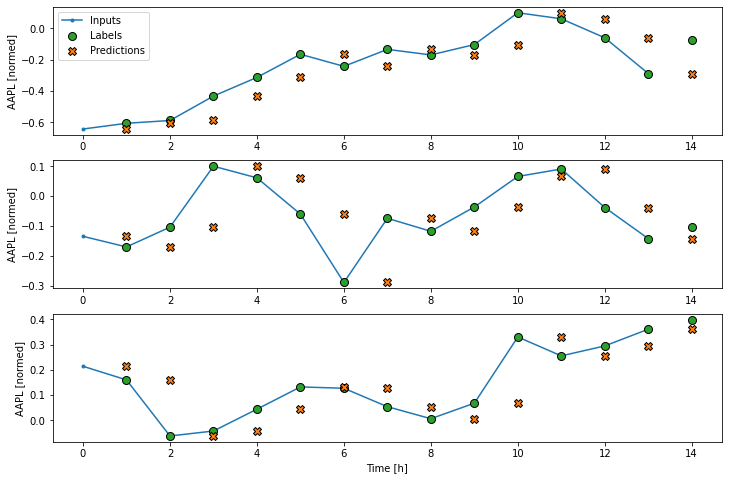

In [30]:
wide_window.plot(baseline)


In the above plots of three examples the single step model is run over the course of 2 weeks. This deserves some explanation:

- The blue `Inputs` line shows the input stock value at each time step. The model receives all features, this plot only shows the stock value.
- The green `Labels` dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.

### Linear model

The simplest **trainable** model you can apply to this task is to insert linear transformation between the input and output. In this case the output from a time step only depends on that step:

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

In [31]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])


In [32]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 161)
Output shape: (32, 1, 1)


This tutorial trains many models, so package the training procedure into a function:

In [33]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history


Train the model and evaluate its performance:

In [34]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
11/11 [==============================] - 0s 10ms/step - loss: 5.2891 - mean_absolute_error: 1.8153 - val_loss: 25.5811 - val_mean_absolute_error: 4.8707
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 2.7143 - mean_absolute_error: 1.3508 - val_loss: 11.8322 - val_mean_absolute_error: 3.1742
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 1.3586 - mean_absolute_error: 0.9570 - val_loss: 5.1794 - val_mean_absolute_error: 1.9149
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.6844 - mean_absolute_error: 0.6713 - val_loss: 2.9268 - val_mean_absolute_error: 1.4010
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4276 - mean_absolute_error: 0.5261 - val_loss: 2.3955 - val_mean_absolute_error: 1.2967
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3251 - mean_absolute_error: 0.4551 - val_loss: 2.3524 - val_mean_absolute_error: 1.2842
Epoch 7/20
11/11 [=======

Like the `baseline` model, the linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.


In [35]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 14, 161)
Output shape: (32, 14, 1)


Here is the plot of its example predictions on the `wide_window`, note how in many cases the prediction is clearly better than just returning the input stock value, but in a few cases it's worse:

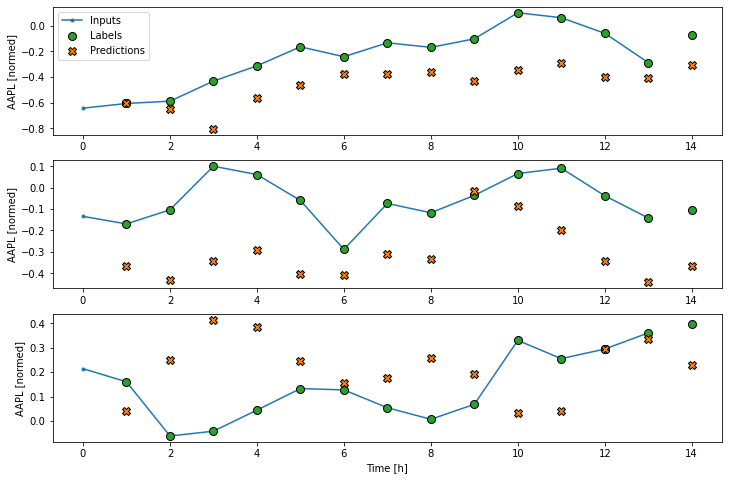

In [36]:
wide_window.plot(linear)


One advantage to linear models is that they're relatively simple to  interpret.
You can pull out the layer's weights and visualize the weight assigned to each input:

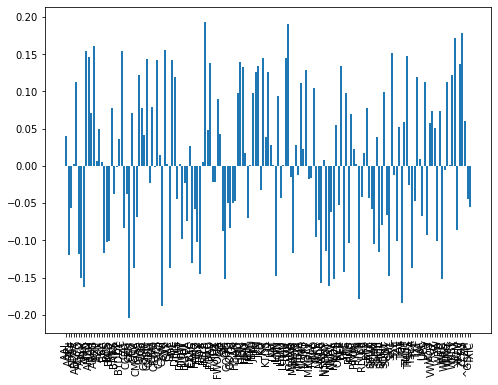

In [37]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)


### Dense

Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models.

Here's a model similar to the `linear` model, except it stacks several a few `Dense` layers between the input and the output: 

In [38]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
11/11 [==============================] - 1s 16ms/step - loss: 0.3313 - mean_absolute_error: 0.4570 - val_loss: 0.2313 - val_mean_absolute_error: 0.3954
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0944 - mean_absolute_error: 0.2417 - val_loss: 0.5918 - val_mean_absolute_error: 0.6868
Epoch 3/20
4/4 [==============================] - 0s 1ms/step - loss: 0.5250 - mean_absolute_error: 0.6579


### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:


The `baseline`, `linear` and `dense` models handled each time step independently. Here the model will take multiple time steps as input to produce a single output.

Create a `WindowGenerator` that will produce batches of three-day inputs and one-day labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [39]:
CONV_WIDTH = 7
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['AAPL'])

conv_window


Total window size: 8
Input indices: [0 1 2 3 4 5 6]
Label indices: [7]
Label column name(s): ['AAPL']

Text(0.5, 1.0, 'Given one week of inputs, predict 1 day into the future.')

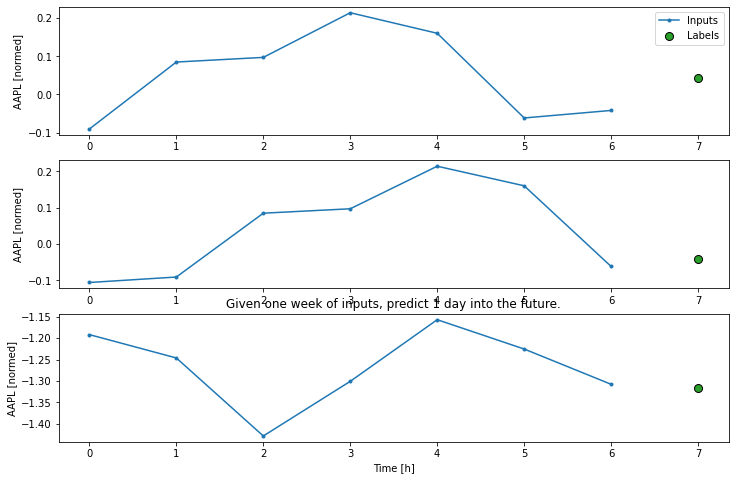

In [40]:
conv_window.plot()
plt.title("Given one week of inputs, predict 1 day into the future.")


You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [41]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [42]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 7, 161)
Output shape: (32, 1, 1)


In [43]:
history = compile_and_fit(multi_step_dense, conv_window)

# IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
11/11 [==============================] - 0s 11ms/step - loss: 0.6153 - mean_absolute_error: 0.5586 - val_loss: 0.5069 - val_mean_absolute_error: 0.5035
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1133 - mean_absolute_error: 0.2712 - val_loss: 0.8898 - val_mean_absolute_error: 0.7556
Epoch 3/20
3/3 [==============================] - 0s 2ms/step - loss: 0.6154 - mean_absolute_error: 0.5968


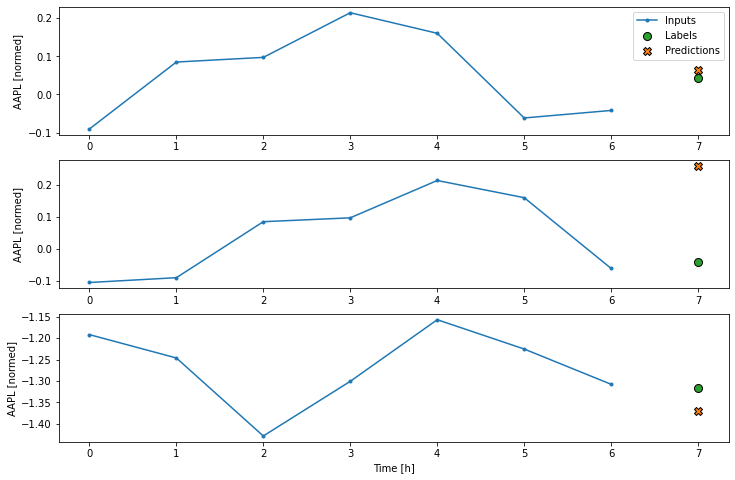

In [44]:
conv_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape. 

In [45]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')
    

Input shape: (32, 14, 161)

ValueError:Exception encountered when calling layer "sequential_2" "                 f"(type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 1127, but received input with shape (32, 2254)

Call arguments received by layer "sequential_2" "                 f"(type Sequential):
  • inputs=tf.Tensor(shape=(32, 14, 161), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next section fix this problem.

### Convolution neural network
 
A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution. 

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [46]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


Run it on an example batch to check that the model produces outputs with the expected shape:

In [47]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 7, 161)
Output shape: (32, 1, 1)


Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [48]:
history = compile_and_fit(conv_model, conv_window)

# IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)


Epoch 1/20
11/11 [==============================] - 0s 13ms/step - loss: 0.4517 - mean_absolute_error: 0.4918 - val_loss: 0.5300 - val_mean_absolute_error: 0.6793
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.1059 - mean_absolute_error: 0.2559 - val_loss: 0.2618 - val_mean_absolute_error: 0.4269
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0554 - mean_absolute_error: 0.1793 - val_loss: 0.0996 - val_mean_absolute_error: 0.2518
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0519 - mean_absolute_error: 0.1721 - val_loss: 0.1834 - val_mean_absolute_error: 0.3563
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0345 - mean_absolute_error: 0.1392 - val_loss: 0.0752 - val_mean_absolute_error: 0.2155
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.0335 - mean_absolute_error: 0.1360 - val_loss: 0.2428 - val_mean_absolute_error: 0.4359
Epoch 7/20
3/3 [===========

The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

If you run it on wider input, it produces wider output:

In [49]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)


Wide window
Input shape: (32, 14, 161)
Labels shape: (32, 14, 1)
Output shape: (32, 8, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a `WindowGenerator` to produce wide windows with a few extra input time steps so the label and prediction lengths match: 

In [50]:
LABEL_WIDTH = 14
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['AAPL'])

wide_conv_window


Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Label column name(s): ['AAPL']

In [51]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 20, 161)
Labels shape: (32, 14, 1)
Output shape: (32, 14, 1)


Now, you can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 14 preceding time steps:

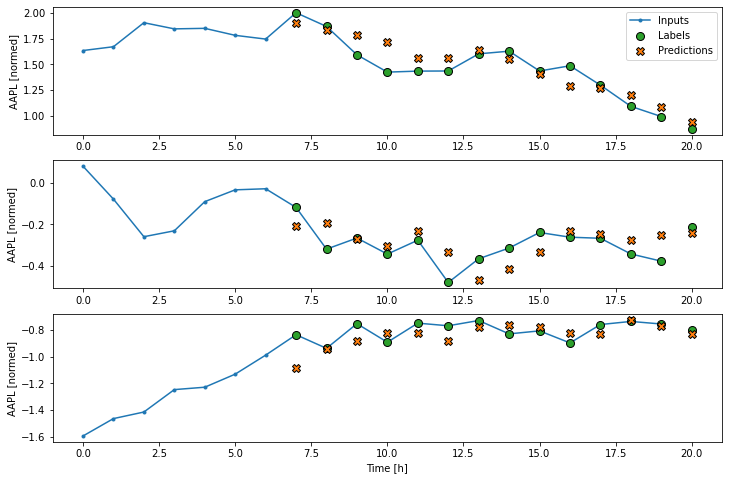

In [52]:
wide_conv_window.plot(conv_model)


### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers. 
  * Training a model on multiple time steps simultaneously.


In [53]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


With `return_sequences=True`, the model can be trained on 2 weeks of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [54]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 14, 161)
Output shape: (32, 14, 1)


In [55]:
history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
11/11 [==============================] - 2s 37ms/step - loss: 0.3664 - mean_absolute_error: 0.4681 - val_loss: 0.6515 - val_mean_absolute_error: 0.6633
Epoch 2/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0961 - mean_absolute_error: 0.2427 - val_loss: 0.3490 - val_mean_absolute_error: 0.4939
Epoch 3/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0540 - mean_absolute_error: 0.1803 - val_loss: 0.3464 - val_mean_absolute_error: 0.4764
Epoch 4/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0391 - mean_absolute_error: 0.1533 - val_loss: 0.3149 - val_mean_absolute_error: 0.4561
Epoch 5/20
11/11 [==============================] - 0s 7ms/step - loss: 0.0313 - mean_absolute_error: 0.1335 - val_loss: 0.3296 - val_mean_absolute_error: 0.4564
Epoch 6/20
3/3 [==============================] - 0s 2ms/step - loss: 0.3218 - mean_absolute_error: 0.4532


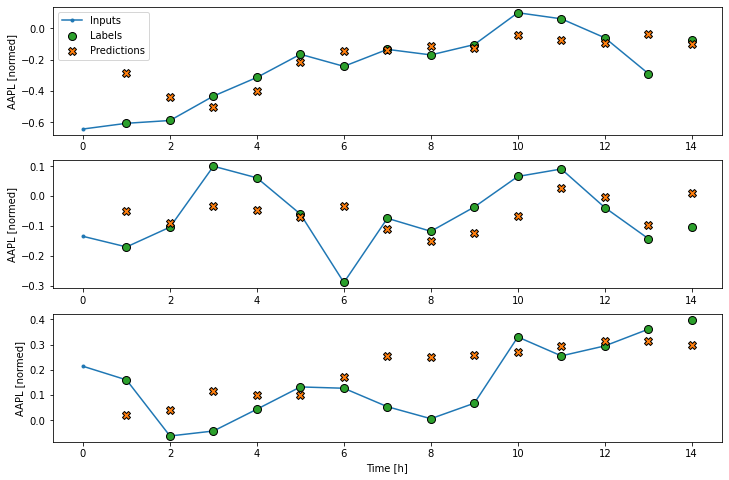

In [56]:
wide_window.plot(lstm_model)


### Performance

With this dataset typically each of the models does slightly better than the one before it:

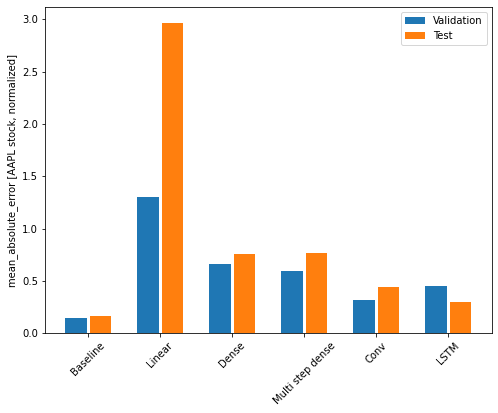

In [57]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [AAPL stock, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [58]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')
    

Baseline    : 0.1611
Linear      : 2.9677
Dense       : 0.7586
Multi step dense: 0.7655
Conv        : 0.4405
LSTM        : 0.2952


### Multi-output models

The models so far all predicted a single output feature, `AAPL`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [59]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 14, 161)
Labels shape (batch, time, features): (32, 14, 161)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [60]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [61]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)


3/3 [==============================] - 0s 1ms/step - loss: 0.0313 - mean_absolute_error: 0.1243


#### Dense

In [62]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=n_stocks)
])


In [63]:
history = compile_and_fit(dense, single_step_window)

# IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
11/11 [==============================] - 1s 14ms/step - loss: 1.0129 - mean_absolute_error: 0.7969 - val_loss: 2.8729 - val_mean_absolute_error: 1.4108
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.7637 - mean_absolute_error: 0.6848 - val_loss: 2.2850 - val_mean_absolute_error: 1.2373
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.5571 - mean_absolute_error: 0.5697 - val_loss: 1.8253 - val_mean_absolute_error: 1.0786
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3888 - mean_absolute_error: 0.4736 - val_loss: 1.4810 - val_mean_absolute_error: 0.9514
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2805 - mean_absolute_error: 0.4030 - val_loss: 1.3277 - val_mean_absolute_error: 0.8839
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.2215 - mean_absolute_error: 0.3586 - val_loss: 1.2309 - val_mean_absolute_error: 0.8415
Epoch 7/20
11/11 [=========

#### RNN


In [64]:
%%time
wide_window = WindowGenerator(
    input_width=14, label_width=14, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=n_stocks)
])

history = compile_and_fit(lstm_model, wide_window)

# IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()


Epoch 1/20
11/11 [==============================] - 2s 38ms/step - loss: 0.9262 - mean_absolute_error: 0.7784 - val_loss: 2.9652 - val_mean_absolute_error: 1.4503
Epoch 2/20
11/11 [==============================] - 0s 8ms/step - loss: 0.7972 - mean_absolute_error: 0.7158 - val_loss: 2.7809 - val_mean_absolute_error: 1.3970
Epoch 3/20
11/11 [==============================] - 0s 8ms/step - loss: 0.6715 - mean_absolute_error: 0.6515 - val_loss: 2.5566 - val_mean_absolute_error: 1.3269
Epoch 4/20
11/11 [==============================] - 0s 7ms/step - loss: 0.5542 - mean_absolute_error: 0.5869 - val_loss: 2.4109 - val_mean_absolute_error: 1.2838
Epoch 5/20
11/11 [==============================] - 0s 7ms/step - loss: 0.4627 - mean_absolute_error: 0.5314 - val_loss: 2.2688 - val_mean_absolute_error: 1.2398
Epoch 6/20
11/11 [==============================] - 0s 7ms/step - loss: 0.3939 - mean_absolute_error: 0.4864 - val_loss: 2.1498 - val_mean_absolute_error: 1.2032
Epoch 7/20
11/11 [=========

<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [65]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta
    

In [66]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        n_stocks,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

# IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()


Epoch 1/20
11/11 [==============================] - 2s 39ms/step - loss: 0.0370 - mean_absolute_error: 0.1279 - val_loss: 0.0317 - val_mean_absolute_error: 0.1253
Epoch 2/20
11/11 [==============================] - 0s 8ms/step - loss: 0.0361 - mean_absolute_error: 0.1265 - val_loss: 0.0347 - val_mean_absolute_error: 0.1330
Epoch 3/20
3/3 [==============================] - 0s 3ms/step - loss: 0.0419 - mean_absolute_error: 0.1499

CPU times: user 2.69 s, sys: 469 ms, total: 3.16 s
Wall time: 2.27 s


#### Performance

Here is the overall performance for these multi-output models.

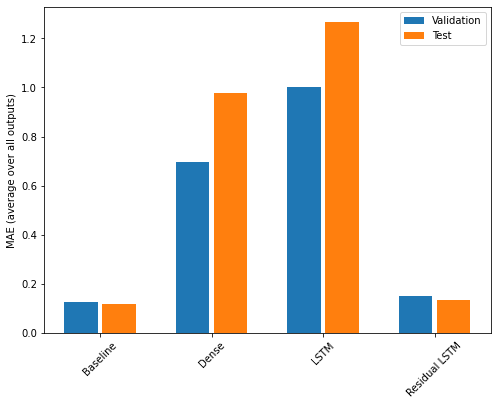

In [67]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()


In [68]:
for name, value in performance.items():
    print(f'{name:15s}: {value[1]:0.4f}')
    

Baseline       : 0.1198
Dense          : 0.9766
LSTM           : 1.2656
Residual LSTM  : 0.1328


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one day into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of daily samples. However, here, the models will learn to predict 2 weeks into the future, given 2 weeks of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 28
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
Label column name(s): None

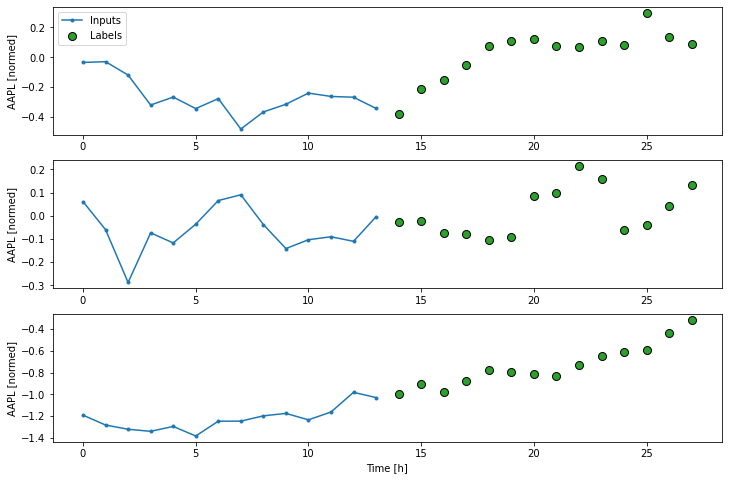

In [69]:
OUT_STEPS = 14
multi_window = WindowGenerator(input_width=14,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window


We do not proceed with multi-output models in this project becaue the problem at hand concerns immediate next-day predictions.
